In [3]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [4]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [5]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# ÂÆö‰πâÂõ†Â≠êÔºÅ

In [6]:
def rsrs_beta_r2_factor(df, window_N=16):
    """
    È´òÊïàËÆ°ÁÆóRSRS_betaÂíåR-squared
    """
    low = df['low']
    high = df['high']
    n = len(df)
    
    # È¢ÑÂàÜÈÖçÊï∞ÁªÑ
    beta = np.full(n, np.nan)
    r_squared = np.full(n, np.nan)
    
    # È¢ÑËÆ°ÁÆóÊªöÂä®ÁªüËÆ°Èáè
    low_mean = low.rolling(window_N).mean()
    high_mean = high.rolling(window_N).mean()
    low_var = low.rolling(window_N).var(ddof=1)
    cov = low.rolling(window_N).cov(high)
    
    # ‰ΩøÁî®ÂêëÈáèÂåñËÆ°ÁÆó
    for i in range(window_N-1, n):
        if low_var[i] < 1e-5:  # ÈÅøÂÖçÈô§‰ª•Èõ∂
            beta[i] = 0
            r_squared[i] = 0
            continue
            
        beta[i] = cov[i] / low_var[i]
        
        # ËÆ°ÁÆóR-squared
        y = high.iloc[i-window_N+1:i+1].values
        y_pred = low.iloc[i-window_N+1:i+1].values * beta[i] + (high_mean[i] - beta[i]*low_mean[i])
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - high_mean[i])**2)
        r_squared[i] = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    beta_series = pd.Series(beta, index=df.index).ffill().fillna(0)
    r2_series = pd.Series(r_squared, index=df.index).ffill().fillna(0)
    return beta_series, r2_series

def rsrs_beta_factor(df, window_N=16):
    """‰ΩøÁî®È´òÊïàÁâàÊú¨ËÆ°ÁÆóÂü∫Á°ÄRSRS beta"""
    beta, _ = rsrs_beta_r2_factor(df, window_N)
    return beta

def rsrs_zscore_factor(df, window_N=16, window_M=300):
    """È´òÊïàËÆ°ÁÆóÊ†áÂáÜÂàÜRSRSÊåáÊ†á"""
    beta = rsrs_beta_factor(df, window_N)
    rolling_mean = beta.rolling(window_M, min_periods=1).mean()
    rolling_std = beta.rolling(window_M, min_periods=1).std().replace(0, 1e-5)
    return (beta - rolling_mean) / rolling_std

def rsrs_zscore_r2_factor(df, window_N=16, window_M=300):
    """È´òÊïàËÆ°ÁÆó‰øÆÊ≠£Ê†áÂáÜÂàÜRSRSÊåáÊ†á"""
    beta, r_squared = rsrs_beta_r2_factor(df, window_N)
    rolling_mean = beta.rolling(window_M, min_periods=1).mean()
    rolling_std = beta.rolling(window_M, min_periods=1).std().replace(0, 1e-5)
    return (beta - rolling_mean) / rolling_std * r_squared

def rsrs_zscore_positive_factor(df, window_N=16, window_M=300):
    """È´òÊïàËÆ°ÁÆóÂè≥ÂÅèÊ†áÂáÜÂàÜRSRSÊåáÊ†á"""
    beta, r_squared = rsrs_beta_r2_factor(df, window_N)
    rolling_mean = beta.rolling(window_M, min_periods=1).mean()
    rolling_std = beta.rolling(window_M, min_periods=1).std().replace(0, 1e-5)
    return ((beta - rolling_mean) / rolling_std) * r_squared * beta

def rsrs_beta_weighted_factor(df, window_N=16):
    """È´òÊïàËÆ°ÁÆóÂä†ÊùÉÂõûÂΩíÁöÑRSRSÊåáÊ†á"""
    low = df['low']
    high = df['high']
    n = len(df)
    beta = np.full(n, np.nan)
    
    # È¢ÑËÆ°ÁÆóÊùÉÈáç
    weights = np.linspace(1, window_N, window_N)
    weights /= weights.sum()
    
    # ‰ΩøÁî®Êõ¥ÂÆâÂÖ®ÁöÑÊñπÂºèËÆ°ÁÆóÂä†ÊùÉÂõûÂΩí
    for i in range(window_N-1, n):
        # Ëé∑ÂèñÁ™óÂè£Êï∞ÊçÆ
        window_low = low.iloc[i-window_N+1:i+1].values
        window_high = high.iloc[i-window_N+1:i+1].values
        
        # ËÆ°ÁÆóÂä†ÊùÉÂùáÂÄº
        w_low_mean = np.dot(window_low, weights)
        w_high_mean = np.dot(window_high, weights)
        
        # ËÆ°ÁÆóÂä†ÊùÉÂçèÊñπÂ∑ÆÂíåÊñπÂ∑Æ
        w_cov = np.dot(weights, (window_low - w_low_mean) * (window_high - w_high_mean))
        w_low_var = np.dot(weights, (window_low - w_low_mean)**2)
        
        # ËÆ°ÁÆóbeta
        if w_low_var < 1e-5:
            beta[i] = 0
        else:
            beta[i] = w_cov / w_low_var
    
    return pd.Series(beta, index=df.index).ffill().fillna(0)

def rsrs_zscore_blunt_factor(df, window_N=16, window_M=300, R=0.8):
    """È´òÊïàËÆ°ÁÆóÈíùÂåñÊ†áÂáÜÂàÜRSRSÊåáÊ†á"""
    beta = rsrs_beta_factor(df, window_N)
    rolling_mean = beta.rolling(window_M, min_periods=1).mean()
    rolling_std = beta.rolling(window_M, min_periods=1).std().replace(0, 1e-5)
    zscore = (beta - rolling_mean) / rolling_std
    
    # ËÆ°ÁÆóÊ≥¢Âä®Áéá
    returns = df['close'].pct_change().fillna(0)
    vol = returns.rolling(window_N, min_periods=1).std()
    
    # ‰ΩøÁî®È´òÊïàÂàÜ‰ΩçÊï∞ËÆ°ÁÆó
    vol_quantile = vol.rolling(window_M, min_periods=1).quantile(0.5)
    
    # ËÆ°ÁÆóÈíùÂåñÂõ†Â≠ê
    blunt_factor = R ** (4 * vol_quantile)
    
    return zscore * blunt_factor

def optimize_weights(df, factors, target):
    """‰ºòÂåñÂõ†Â≠êÊùÉÈáç"""
    X = pd.DataFrame({name: factor(df) for name, factor in factors.items()})
    y = target(df)
    
    # Âà†Èô§ÂåÖÂê´NaNÁöÑË°å
    valid_mask = X.notna().all(axis=1) & y.notna()
    X_valid = X[valid_mask]
    y_valid = y[valid_mask]
    
    if len(X_valid) == 0:
        return np.ones(len(factors)) / len(factors)  # ÈªòËÆ§Á≠âÊùÉÈáç
    
    model = LinearRegression()
    model.fit(X_valid, y_valid)
    return model.coef_

def improved_factor(df):
    """ÁªÑÂêàÂ§ö‰∏™RSRSÊåáÊ†áÁîüÊàêÊîπËøõÂõ†Â≠ê"""
    # ‰∏ÄÊ¨°ÊÄßËÆ°ÁÆóÂü∫Á°ÄbetaÂíåR-squared
    beta, r_squared = rsrs_beta_r2_factor(df, window_N=16)
    
    # ËÆ°ÁÆóÂêÑ‰∏™RSRSÊåáÊ†áÔºàÈÅøÂÖçÈáçÂ§çËÆ°ÁÆóÔºâ
    rsrs_zscore = rsrs_zscore_factor(df, window_N=16, window_M=300)
    rsrs_zscore_r2 = rsrs_zscore_r2_factor(df, window_N=16, window_M=300)
    rsrs_zscore_positive = rsrs_zscore_positive_factor(df, window_N=16, window_M=300)
    rsrs_beta_weighted = rsrs_beta_weighted_factor(df, window_N=16)
    rsrs_zscore_blunt = rsrs_zscore_blunt_factor(df, window_N=16, window_M=300, R=0.8)
    
    # ÂàõÂª∫Âõ†Â≠êÂ≠óÂÖ∏
    factors_dict = {
        'rsrs_beta': beta,
        'rsrs_zscore': rsrs_zscore,
        'rsrs_zscore_r2': rsrs_zscore_r2,
        'rsrs_zscore_positive': rsrs_zscore_positive,
        'rsrs_beta_weighted': rsrs_beta_weighted,
        'rsrs_zscore_blunt': rsrs_zscore_blunt
    }
    
    # Ê†áÂáÜÂåñÊâÄÊúâÂõ†Â≠ê
    standardized = {}
    for name, series in factors_dict.items():
        mean_val = series.mean()
        std_val = series.std()
        if std_val < 1e-5:
            standardized[name] = series - mean_val
        else:
            standardized[name] = (series - mean_val) / std_val
    
    # ÂÆö‰πâÂõ†Â≠êÂáΩÊï∞
    factors = {
        name: lambda df, s=standardized[name]: s 
        for name in factors_dict.keys()
    }
    
    # ÁõÆÊ†áÂáΩÊï∞ÔºöÊú™Êù•10ÊúüÊî∂ÁõäÁéá
    target = lambda df: df['close'].pct_change(10).shift(-10)
    
    # ‰ºòÂåñÊùÉÈáç
    try:
        weights = optimize_weights(df, factors, target)
    except Exception as e:
        print(f"ÊùÉÈáç‰ºòÂåñÂ§±Ë¥•: {e}")
        weights = np.ones(len(factors)) / len(factors)
    
    # ÁªÑÂêàÂõ†Â≠ê
    combined_factor = pd.Series(0, index=df.index)
    for name, weight in zip(factors.keys(), weights):
        combined_factor += weight * standardized[name]
    
    # ÊúÄÁªàÂΩí‰∏ÄÂåñÂ§ÑÁêÜ
    abs_mean = combined_factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    return combined_factor / abs_mean

In [7]:
evaluator.set_factor(
    factor_data_or_func=improved_factor,
    factor_name='improved_factor_with_rsrs'
)


üìä ÂçïÂ∏ÅÁßç (single) ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
--------------------------------------------------
üìà Âπ≥Á®≥ÊÄßÊ£ÄÈ™å (ADF):
   p_value: 0.000000
   ÊòØÂê¶Âπ≥Á®≥: ÊòØ
üîó Áõ∏ÂÖ≥ÊÄßÂàÜÊûê:
   IC (Pearson): 0.014790
   Rank_IC (Spearman): 0.027601
üìä ‰ø°ÊÅØÊØîÁéá:
   IR: 0.402161
   ÊúâÊïàÂàÜÁªÑÊï∞: 10
üìä Âõ†Â≠êÂàÜÂ∏É:
üìã Êï∞ÊçÆÊ¶ÇÂÜµ:
   Êï∞ÊçÆÈïøÂ∫¶: 130747
   Âõ†Â≠êÂàó: improved_factor_with_rsrs
   Êî∂ÁõäÁéáÂàó: future_return
   Êú™Êù•Êî∂ÁõäÂë®Êúü: 10
--------------------------------------------------

üñºÔ∏è  ÂçïÂ∏ÅÁßç (single) ÂõæÁâáÂ±ïÁ§∫:
----------------------------------------
üìä ÊòæÁ§∫ÂàÜÁªÑÂàÜÊûêÂõæ...


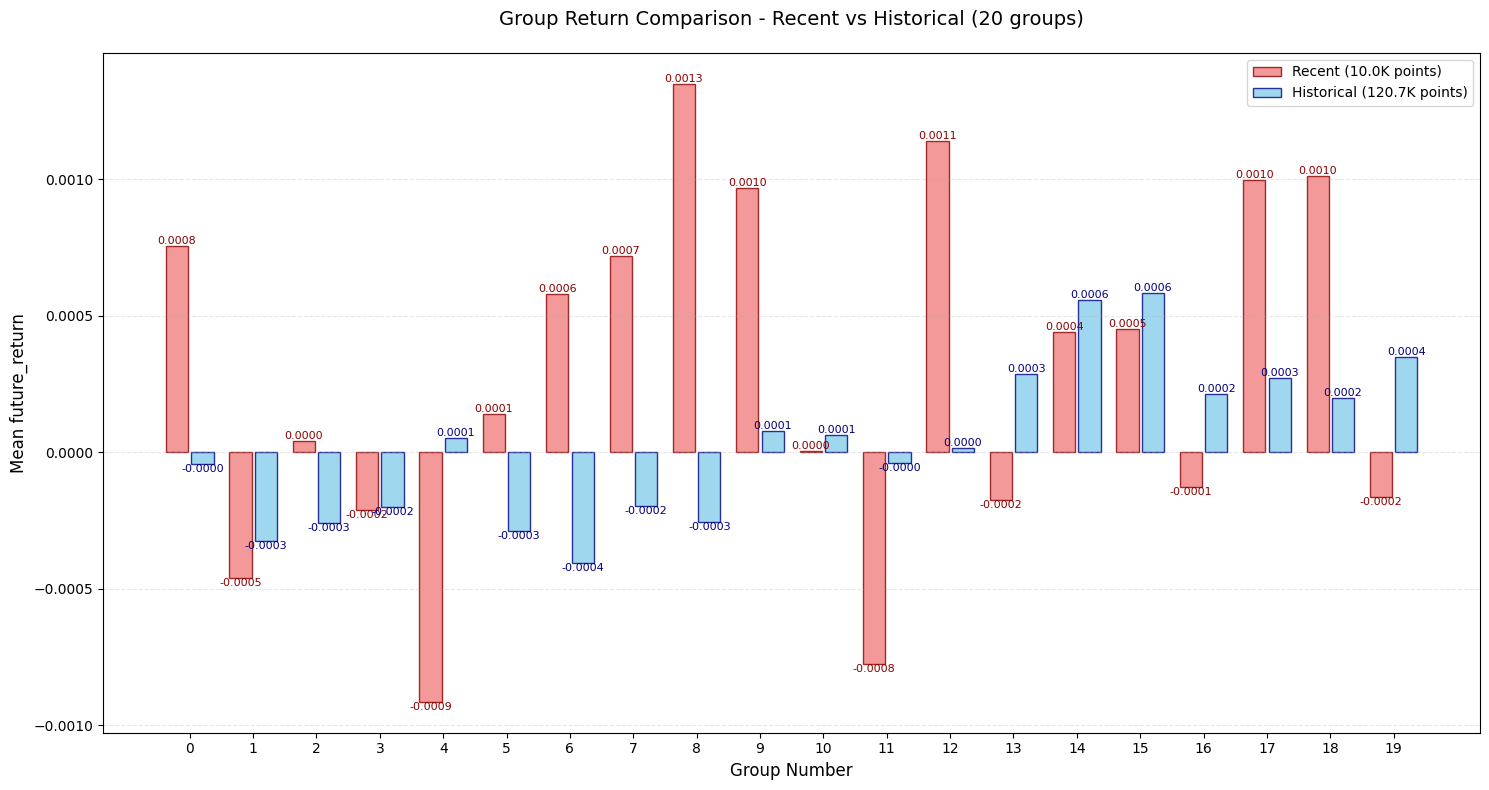

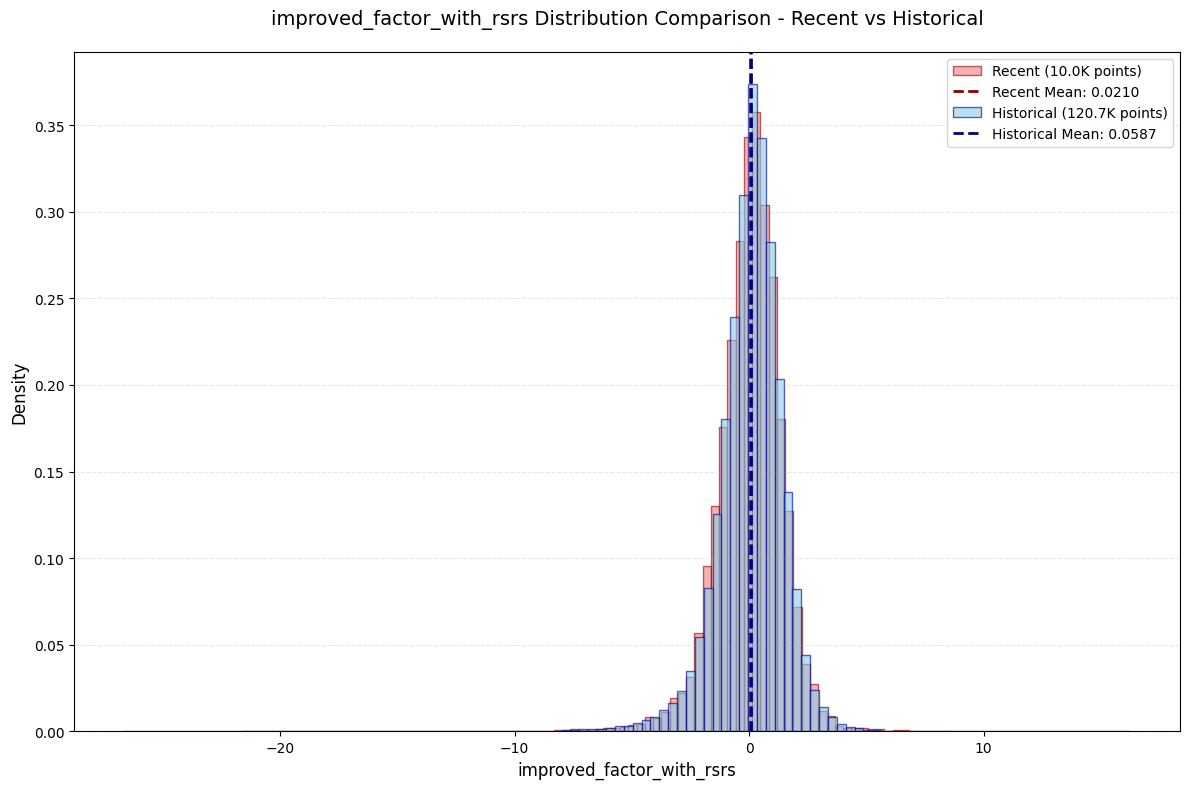

üìà ÊòæÁ§∫Âõ†Â≠êÂàÜÂ∏ÉÂõæ...
‚úÖ Â∑≤ÊòæÁ§∫ 2 ‰∏™ÂõæÁâá
----------------------------------------


In [8]:
result=evaluator.run_full_evaluation(run_stationarity_test=True)

In [ ]:
sig=improved_factor(df)
plt.scatter(sig, result['future_return'])

NameError: name 'plt' is not defined